# ANN(Multi-Layer Perceptron)

[Contents]
1. Over-fitting vs Under-fitting  
2. Nodes수 에 따른 성과비교  
3. Layer Depth에 따른 성과비교  
4. 일반화 성능비교 (EarlyStopping+Dropout)

[Data]  
Heart Disease Data set (Classification)  
https://archive.ics.uci.edu/dataset/45/heart+disease
shape : 303*13
  
[Task]
1. 아래 2개의 데이터 중 택일하여  
 - 활용데이터1 : Adult(Census Income)(2)
 - https://archive.ics.uci.edu/dataset/2/adult
 - 활용데이터2 : Bank Marketing(222)
 - https://archive.ics.uci.edu/dataset/222/bank+marketing


[Note]


In [1]:
#  UCI Machine Learning Data Load Library
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# 1. Data Loading
print("=== Data Loading ===")
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

df = pd.DataFrame(X, columns=heart_disease.feature_names)
df['target'] = y

print(f"Data Shape: {df.shape}")
print(f"Info: {df.info()}")
print(f"Samples: {df.head(5)}")

=== Data Loading ===
Data Shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
Info: None
Samples:    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3     

In [6]:
# 2. EDA
print("\n결측치 확인:")
print(df.isnull().sum())

print("\n타겟 변수 분포:")
print(f"Target Class Name: {heart_disease.target_names}")
target_counts = df['target'].value_counts()
print(target_counts)
print(f"비율: {target_counts / len(df) * 100}")



결측치 확인:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

타겟 변수 분포:
Target Class Name: None
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
비율: target
0    54.125413
1    18.151815
2    11.881188
3    11.551155
4     4.290429
Name: count, dtype: float64


In [7]:
# 3. Data Preprocessing

# Handle missing values
X = X.fillna(X.mean())
y = (y > 0).astype(int).values.ravel()  # Convert to binary classification

# Train/Validation/Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]
print(f"Number of features after preprocessing: {n_features}")

Number of features after preprocessing: 13


In [8]:
# 4. Model Functions : MLP생성모듈
def create_underfitting_model(input_dim):
    """Underfitting model - too simple"""
    model = keras.Sequential([
        layers.Dense(2, activation='relu', input_shape=(input_dim,)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_balanced_model(input_dim, hidden_units):
    """Well-balanced model"""
    model = keras.Sequential([
        layers.Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_overfitting_model(input_dim):
    """Overfitting model - too complex"""
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_deep_model(input_dim, hidden_units, n_layers):
    """Deep model for depth experiments"""
    model = keras.Sequential()
    model.add(layers.Dense(hidden_units, activation='relu', input_shape=(input_dim,)))

    for _ in range(n_layers - 1):
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model Training Function
def train_model(model, model_name, epochs=100):
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=0
    )

    # Test performance evaluation
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")

    return history, test_accuracy


In [9]:
# 5. 실험1: Underfitting vs Overfitting
print("\n=== Experiment 1: Underfitting vs Overfitting ===")

models_comparison = {}

# Underfitting model
under_model = create_underfitting_model(n_features)
under_history, under_acc = train_model(under_model, "Underfitting Model")
models_comparison['Underfitting'] = {'history': under_history, 'accuracy': under_acc}

# Balanced model (n nodes)
balanced_model = create_balanced_model(n_features, n_features)
balanced_history, balanced_acc = train_model(balanced_model, f"Balanced Model ({n_features} nodes)")
models_comparison['Balanced'] = {'history': balanced_history, 'accuracy': balanced_acc}

# Overfitting model
over_model = create_overfitting_model(n_features)
over_history, over_acc = train_model(over_model, "Overfitting Model")
models_comparison['Overfitting'] = {'history': over_history, 'accuracy': over_acc}



=== Experiment 1: Underfitting vs Overfitting ===
Underfitting Model - Test Accuracy: 0.8361
Balanced Model (13 nodes) - Test Accuracy: 0.8525
Overfitting Model - Test Accuracy: 0.8033


In [10]:
# 6. 실험 2: Hidden Layer Node수에 따른 비교 (n vs 2n)
print("\n=== Experiment 2: Hidden Layer Node Comparison ===")

node_comparison = {}

# n nodes
model_n = create_balanced_model(n_features, n_features)
history_n, acc_n = train_model(model_n, f"{n_features} Nodes Model")
node_comparison[f'{n_features} Nodes'] = {'history': history_n, 'accuracy': acc_n}

# 2n nodes
model_2n = create_balanced_model(n_features, 2*n_features)
history_2n, acc_2n = train_model(model_2n, f"{2*n_features} Nodes Model")
node_comparison[f'{2*n_features} Nodes'] = {'history': history_2n, 'accuracy': acc_2n}



=== Experiment 2: Hidden Layer Node Comparison ===
13 Nodes Model - Test Accuracy: 0.9344
26 Nodes Model - Test Accuracy: 0.8689


In [11]:
# 7. 실험 3: Hidden Layer Depth 에 따른 비교 (노드수 = 2n으로 고정, n=속성수+타겟수)
print("\n=== Experiment 3: Hidden Layer Depth Comparison ===")

depth_comparison = {}
depths = [1, 2, 3, 4, 5]

for depth in depths:
    model = create_deep_model(n_features, 2*n_features, depth)
    history, accuracy = train_model(model, f"{depth}-Layer Model", epochs=50)
    depth_comparison[f'{depth} Layers'] = {'history': history, 'accuracy': accuracy}



=== Experiment 3: Hidden Layer Depth Comparison ===
1-Layer Model - Test Accuracy: 0.8689
2-Layer Model - Test Accuracy: 0.8525
3-Layer Model - Test Accuracy: 0.7869
4-Layer Model - Test Accuracy: 0.8689
5-Layer Model - Test Accuracy: 0.8852


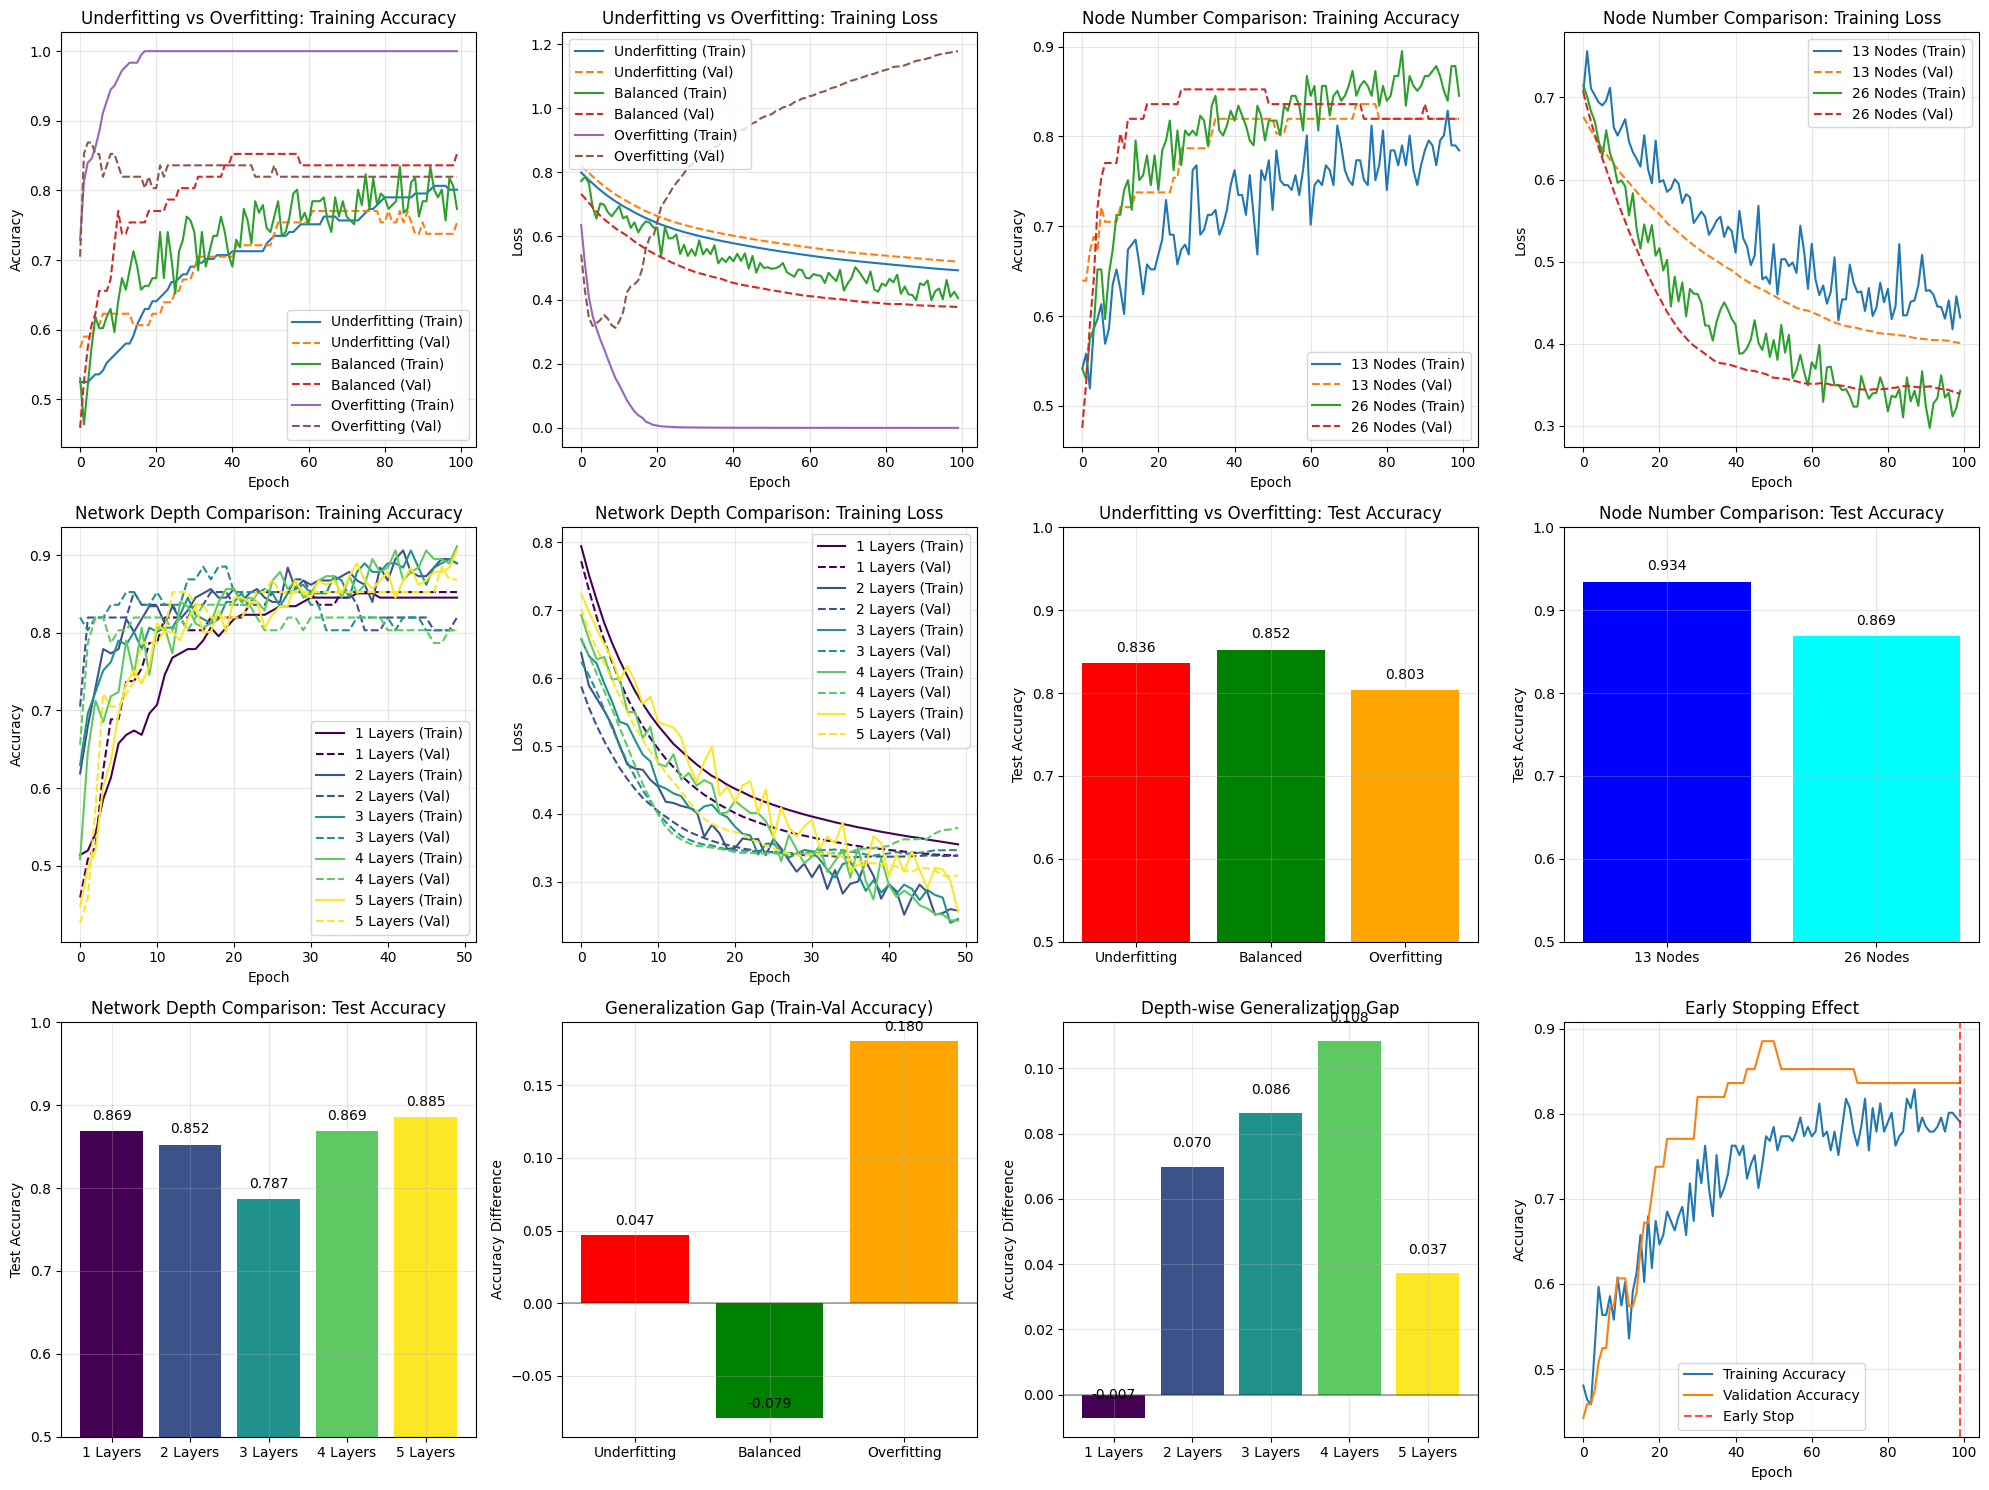


=== Experiment Results Summary ===
1. Underfitting vs Overfitting:
   Underfitting: Test Accuracy 0.8361
   Balanced: Test Accuracy 0.8525
   Overfitting: Test Accuracy 0.8033

2. Node Number Comparison (n=13):
   13 Nodes: Test Accuracy 0.9344
   26 Nodes: Test Accuracy 0.8689

3. Network Depth Comparison (26 nodes):
   1 Layers: Test Accuracy 0.8689
   2 Layers: Test Accuracy 0.8525
   3 Layers: Test Accuracy 0.7869
   4 Layers: Test Accuracy 0.8689
   5 Layers: Test Accuracy 0.8852

4. Final Model (Early Stopping): Test Accuracy 0.8361


In [12]:
# 8. 실험결과 시각화: Visualization

plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 8-1. Underfitting vs Overfitting Learning Curves
ax1 = plt.subplot(3, 4, 1)
for name, data in models_comparison.items():
    plt.plot(data['history'].history['accuracy'], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_accuracy'], '--', label=f'{name} (Val)')
plt.title('Underfitting vs Overfitting: Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 4, 2)
for name, data in models_comparison.items():
    plt.plot(data['history'].history['loss'], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_loss'], '--', label=f'{name} (Val)')
plt.title('Underfitting vs Overfitting: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 8-2. Node Number Comparison Learning Curves
ax3 = plt.subplot(3, 4, 3)
for name, data in node_comparison.items():
    plt.plot(data['history'].history['accuracy'], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_accuracy'], '--', label=f'{name} (Val)')
plt.title('Node Number Comparison: Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 4, 4)
for name, data in node_comparison.items():
    plt.plot(data['history'].history['loss'], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_loss'], '--', label=f'{name} (Val)')
plt.title('Node Number Comparison: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 8-3. Depth Comparison Learning Curves
ax5 = plt.subplot(3, 4, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(depths)))
for i, (name, data) in enumerate(depth_comparison.items()):
    plt.plot(data['history'].history['accuracy'], color=colors[i], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_accuracy'], '--', color=colors[i], label=f'{name} (Val)')
plt.title('Network Depth Comparison: Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 4, 6)
for i, (name, data) in enumerate(depth_comparison.items()):
    plt.plot(data['history'].history['loss'], color=colors[i], label=f'{name} (Train)')
    plt.plot(data['history'].history['val_loss'], '--', color=colors[i], label=f'{name} (Val)')
plt.title('Network Depth Comparison: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 8-4. Test Performance Comparison Bar Charts
ax7 = plt.subplot(3, 4, 7)
model_names = list(models_comparison.keys())
accuracies = [models_comparison[name]['accuracy'] for name in model_names]
bars = plt.bar(model_names, accuracies, color=['red', 'green', 'orange'])
plt.title('Underfitting vs Overfitting: Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0.5, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 4, 8)
node_names = list(node_comparison.keys())
node_accs = [node_comparison[name]['accuracy'] for name in node_names]
bars = plt.bar(node_names, node_accs, color=['blue', 'cyan'])
plt.title('Node Number Comparison: Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0.5, 1.0)
for bar, acc in zip(bars, node_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

ax9 = plt.subplot(3, 4, 9)
depth_names = list(depth_comparison.keys())
depth_accs = [depth_comparison[name]['accuracy'] for name in depth_names]
bars = plt.bar(depth_names, depth_accs, color=colors)
plt.title('Network Depth Comparison: Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0.5, 1.0)
for bar, acc in zip(bars, depth_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 8-5. Generalization Performance Analysis (Train vs Validation Accuracy Gap)
ax10 = plt.subplot(3, 4, 10)
generalization_gap = []
model_labels = []

for name, data in models_comparison.items():
    final_train_acc = data['history'].history['accuracy'][-1]
    final_val_acc = data['history'].history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    generalization_gap.append(gap)
    model_labels.append(name)

bars = plt.bar(model_labels, generalization_gap, color=['red', 'green', 'orange'])
plt.title('Generalization Gap (Train-Val Accuracy)')
plt.ylabel('Accuracy Difference')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for bar, gap in zip(bars, generalization_gap):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{gap:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 8-6. Depth-wise Generalization Performance
ax11 = plt.subplot(3, 4, 11)
depth_gen_gap = []
for name, data in depth_comparison.items():
    final_train_acc = data['history'].history['accuracy'][-1]
    final_val_acc = data['history'].history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    depth_gen_gap.append(gap)

bars = plt.bar(depth_names, depth_gen_gap, color=colors)
plt.title('Depth-wise Generalization Gap')
plt.ylabel('Accuracy Difference')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for bar, gap in zip(bars, depth_gen_gap):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{gap:.3f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 8-7. Learning Curve Comparison (Early Stopping Effect)
ax12 = plt.subplot(3, 4, 12)
best_model = create_balanced_model(n_features, n_features)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_es = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

plt.plot(history_es.history['accuracy'], label='Training Accuracy')
plt.plot(history_es.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_es.history['accuracy'])-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
plt.title('Early Stopping Effect')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Results Summary
print("\n=== Experiment Results Summary ===")
print("1. Underfitting vs Overfitting:")
for name, data in models_comparison.items():
    print(f"   {name}: Test Accuracy {data['accuracy']:.4f}")

print(f"\n2. Node Number Comparison (n={n_features}):")
for name, data in node_comparison.items():
    print(f"   {name}: Test Accuracy {data['accuracy']:.4f}")

print(f"\n3. Network Depth Comparison ({2*n_features} nodes):")
for name, data in depth_comparison.items():
    print(f"   {name}: Test Accuracy {data['accuracy']:.4f}")

print(f"\n4. Final Model (Early Stopping): Test Accuracy {best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]:.4f}")
